In [139]:
import sys
sys.path.append('/home/yuncong/Brain/pipeline_scripts')

import matplotlib
%matplotlib inline
#from IPython.display import display
#matplotlib.use('GTkAgg')
import matplotlib.pyplot as plt
import pickle
import os
from os import path
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.cluster import KMeans
from sklearn import svm
from numpy.linalg import lstsq
import numpy as np
import sys
import utilities2014
reload(utilities2014)
from utilities2014 import *
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC


from sklearn.preprocessing import MinMaxScaler

In [140]:
pcklPath = "/home/iizhaki/oasis/WebStem/pickles/"

mapped = pickle.load(open(pcklPath + "mapped.pck", "rb"))
props = pickle.load(open(pcklPath + "props.pck", "rb"))
hists = pickle.load(open(pcklPath + "hists.pck", "rb"))
refs = pickle.load(open(pcklPath + "refs.pck", "rb"))

In [141]:
tripletsPath = "/home/iizhaki/WebStem/triplets/"
imgsPath = "/home/iizhaki/WebStem/photos/"

In [142]:
os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

In [149]:
def collectPageData(pPath, pData):
    redRef = ""
    blueRef = ""

    with open(pPath) as pFile:
        for pLine in pFile:
            pSplit = pLine.split()
            if len(pSplit) < 6:  # Maybe comment or blank space
                continue
            
            #print pSplit

            pName = pSplit[4]
            pColor = pSplit[5]
            
            # Initialize sets
            if "gold" in pColor:
                boundNum = int(pName.split("_")[3])
                superpixel = int(pName.split("_")[4])
                
                if "red" in pSplit[6]:
                    redRef = boundNum
                    if redRef not in pData:
                        pData[redRef] = set()
                    pData[redRef].add(superpixel)
                elif "blue" in pSplit[6]:
                    blueRef = boundNum
                    if blueRef not in pData:
                        pData[blueRef] = set()
                    pData[blueRef].add(superpixel)
                else:
                    print "ERROR!"
                    return "ERROR!"
                
                continue
            
            boundNum = int(pName.split("_")[2])
            superpixel = int(pName.split("_")[3])

            if "red" in pColor:
                if boundNum == redRef:
                    pData[redRef].add(superpixel)

            if "blue" in pColor:
                if boundNum == blueRef:
                    pData[blueRef].add(superpixel)

    return "Ok"

In [150]:
pagesPath = [(tripletsPath + f) for f in os.listdir(tripletsPath)]

In [151]:
pData = {}

for pageFile in pagesPath:
    print collectPageData(pageFile, pData)
    
print pData

Ok
Ok
{9: set([224, 228, 229, 232, 269, 142, 175, 273, 155, 223]), 10: set([204, 202, 236, 207, 178, 250, 271, 284]), 11: set([160, 227, 235, 140, 238, 239, 112, 337, 338, 182, 216, 271, 284, 287])}


In [152]:
# 30 sections in total
collectHists = {}

for section in pData:
    # Initialize array of histograms
    collectHists[section] = []
    
    for superpixel in pData[section]:
        collectHists[section].append(hists[section][superpixel])

In [155]:
# [(11, 7), (13, 5), (14, 12)], [(12, 12)]
# [(11, 22), (12, 11)], [(13, 25), (14, 17)]

# Some manual work:
predXs = []
predYs = []

for section in [9, 10]:
    for currHist in collectHists[section]:
        predXs.append(currHist)
        predYs.append(1)
        
for section in [11]:
    for currHist in collectHists[section]:
        predXs.append(currHist)
        predYs.append(-1)
        
#predXs = np.array(predXs) * 1.0 / np.max(predXs)

In [156]:
print predXs[0:2], predYs[0:2]
print predXs[-2:], predYs[-2:]

# print predYs[0][0], predYs[1][0]

[[477, 24, 80, 441, 0, 35, 86, 88, 188, 718, 66, 545, 316, 10], [465, 118, 60, 7, 0, 0, 200, 9, 380, 612, 60, 961, 263, 0]] [1, 1]
[[268, 114, 0, 0, 0, 56, 209, 142, 317, 208, 325, 422, 516, 223], [324, 92, 26, 117, 0, 67, 294, 133, 507, 312, 372, 424, 911, 203]] [-1, -1]


In [157]:
import shutil

allFiles = os.listdir(imgsPath)
print allFiles[0]

ref_26_1435_1743_1223_68_hist.png


In [158]:
for section in pData:
    spxs = pData[section]
    break ############
    for sp in spxs:
        exp = "ref_" + str(section) + "_" + str(sp)
        for fn in allFiles:
            if exp in fn:
                thedir = "/home/iizhaki/WebStem/temp/" + str(section)
                try:
                    os.stat(thedir)
                except:
                    os.mkdir(thedir)       

                shutil.copy2(imgsPath + "/" + fn, "/home/iizhaki/WebStem/temp/" + str(section))
    
        
        

In [159]:
predYs_arr = np.array(predYs)
predXs_arr  = np.array(predXs)
predXs_arr.shape

(32, 14)

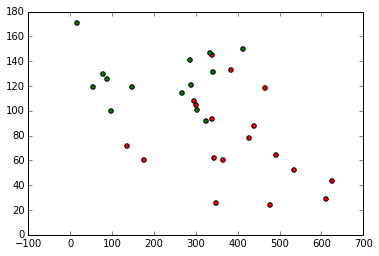

In [160]:
plt.scatter(predXs_arr[predYs_arr==1,0], predXs_arr[predYs_arr==1,1], c='r')
plt.scatter(predXs_arr[predYs_arr==-1,0], predXs_arr[predYs_arr==-1,1], c='g')
plt.show()

#plt.savefig("/home/iizhaki/WebStem/temp/img_[(11,22),(12,11)]vs.[(13,25),(14,17)].png")

In [162]:
# Training SVM
X = predXs
y = predYs

X = np.array(X).astype(float)
#scaler = MinMaxScaler().fit(X)
#X = scaler.transform(X)

In [163]:
#X = [np.array(x) * 1.0 / np.max(x) for x in predXs]

#thetax, _, _, _ = np.linalg.lstsq(X, y)

#del clf
#clf = SGDRegressor()
#clf.fit(X, y)

#clf = svm.SVC(verbose = True)
#clf.fit(X, y) 

param_grid = {'C': [1, 1e1, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10], }
#clf = GridSearchCV(SVC(kernel='poly', class_weight='auto', degree = 14), param_grid)
#clf = SVC(verbose = True, kernel='poly', class_weight='auto', degree=4) 
clf = SVC(verbose = True, kernel='poly', class_weight='auto', degree=5) 
clf = clf.fit(X, y)

#clf = Perceptron()
#clf.fit(X, y)


print predYs

[LibSVM][1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [164]:
def predict(data, theta):
    return np.dot(np.array(data), np.array(theta))

In [165]:
trueYes = 0
totalYes = 0
trueNo = 0
totalNo = 0

predictions = clf.predict(X)
print predictions 

for i in range(len(predictions)):
    #thePred =  predict(predXs[i], thetax)
    thePred = predictions[i]
    if (predYs[i] > 0):
        totalYes += 1
        if (thePred > 0.):
            trueYes += 1
    else:
        totalNo += 1
        if (thePred < 0):
            trueNo += 1
    
print "===================="
print trueYes * 1.0 / totalYes
print trueNo * 1.0 / totalNo

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1]
1.0
1.0


In [166]:
#print clf.coef_ 
#print clf.intercept_ 

In [167]:
# [(25, 22), (27, 28)] vs. [(26, 3)]
# [(25, 22), (27, 28)] vs. [(26, 5)]
# [(11, 7), (13, 5), (14, 12)] vs. [(12, 12)]
# [(11, 22), (12, 11)], [(13, 25), (14, 17)]


viss = {}
#for cSection in [25, 26, 27]:
for cSection in [11]:
    pos26 = []
    scores26 = []
    DM = DataManager(generate_hierarchy = False, stack = 'RS141', resol = 'x5', section = cSection)
    cSupporters = DM.load_pipeline_result('nonoverlappingSupporters', 'pkl')
    print pData[cSection]
    #viss[cSection] = DM.visualize_cluster(pData[cSection])

    tuples = []
    for cBoundary in range(len(cSupporters)):        
        total = 0
        truePos = 0
        trueNeg = 0
        
        scores = []
        
        cSample = (cSection, cBoundary)
        pot = []
        for s in cSupporters[cBoundary]:
            total += 1
            hs = hists[cSection][s]
            hs = np.array(hs).astype(float)
            #hs = scaler.transform(hs)
            #print clf.decision_function(hs)
            #if clf.predict(hs)[0] > 0:
            #if cBoundary == 0:
                 #print clf.decision_function(hs)
            
            scores.append(clf.decision_function(hs)[0])
            if clf.decision_function(hs) >= 1:
                truePos += 1
                pot.append(s)

        value = truePos * 100.0 / total
        #if value < 70:
         #   continue
        tuples.append((value, cBoundary))
        
        scores = np.array(scores)
        scores26.append((np.mean(scores), cBoundary))
        if cSection == 26:
            pos26 += pot
        #print cSample, ": Using classifier results:", truePos * 100.0 / total    

    print "Section ", cSection, ": ", sorted(tuples, reverse=True)
    print "============================================"
    scores26 = sorted(scores26, reverse=True)
    for i in range(len(scores26)):
        if scores26[i][0] > 0:
            print "Boudnary: ", scores26[i][1], ", Score: ", scores26[i][0]

set([160, 227, 235, 140, 238, 239, 112, 337, 338, 182, 216, 271, 284, 287])
Section  11 :  [(100.0, 28), (100.0, 27), (100.0, 21), (100.0, 18), (100.0, 13), (100.0, 12), (100.0, 11), (100.0, 7), (100.0, 4), (100.0, 3), (100.0, 2), (100.0, 0), (80.0, 15), (72.22222222222223, 14), (65.0, 6), (58.8235294117647, 25), (57.0, 1), (41.666666666666664, 24), (37.5, 8), (36.36363636363637, 5), (28.571428571428573, 26), (24.444444444444443, 23), (11.290322580645162, 20), (11.11111111111111, 19), (5.2631578947368425, 22), (4.545454545454546, 17), (3.4482758620689653, 10), (0.0, 16), (0.0, 9)]
Boudnary:  13 , Score:  7.94635555362
Boudnary:  27 , Score:  5.36045504225
Boudnary:  25 , Score:  3.47889563446
Boudnary:  21 , Score:  2.74143986062
Boudnary:  3 , Score:  2.74095360378
Boudnary:  12 , Score:  2.71885673072
Boudnary:  0 , Score:  2.69330269405
Boudnary:  2 , Score:  2.66949699882
Boudnary:  7 , Score:  2.51893777146
Boudnary:  28 , Score:  2.45804824601
Boudnary:  18 , Score:  2.4533702191

In [134]:
DM = DataManager(generate_hierarchy = False, stack = 'RS141', resol = 'x5', section = 26)
cSupporters = DM.load_pipeline_result('nonoverlappingSupporters', 'pkl')

display(DM.visualize_cluster(pos26))

/oasis/scratch/iizhaki/temp_project/WebStem/iPython/tmp.jpg

In [170]:
DM = DataManager(generate_hierarchy = False, stack = 'RS141', resol = 'x5', section = 10)
matchings = DM.load_pipeline_result('DBoundaries10With11', 'npy')



In [171]:
print matchings[np.argsort(matchings[:, 3]), 3] 
print np.argsort(matchings[:, 3])

[ 1.30044443  2.44392935  2.64190043  2.80692862         inf         inf
         inf         inf         inf         inf         inf         inf
         inf         inf         inf         inf         inf         inf
         inf         inf         inf         inf         inf         inf
         inf         inf         inf         inf         inf]
[ 9 15 26 14 25 24 23 22 21 20 19 18 17 16  0 13 12 11 10  8  7  6  5  4  3
  2  1 27 28]


In [137]:
DM = DataManager(generate_hierarchy = False, stack = 'RS141', resol = 'x5', section = 2)
matchings = DM.load_pipeline_result('DBoundaries2With4', 'npy')

print matchings[np.argsort(matchings[:, 8]), 8] 
print np.argsort(matchings[:, 8])

[ 0.66467065  0.66958352  0.8229889   0.85319059  0.87260952  0.88394716
  0.95227919  0.96957002  0.97706937  0.98381796  1.01106212  1.05428913
  1.05961905  1.0682539   1.08313887  1.22246128  1.56025875  1.6679087
  2.01896999  2.2753929          inf         inf         inf         inf
         inf         inf         inf         inf         inf         inf]
[24 12 29 23 10 14 21 27  4 28  1 25 20 22  9 13  3  8  2 16  6 26 17 18  5
 15 11  7 19  0]


In [175]:
DM = DataManager(generate_hierarchy = False, stack = 'RS141', resol = 'x5', section = 2)
display(DM.visualize_cluster

/oasis/scratch/iizhaki/temp_project/WebStem/iPython/tmp.jpg

/oasis/scratch/iizhaki/temp_project/WebStem/iPython/tmp.jpg

In [202]:
def visualize_cluster(self, cluster, text=False, highlight_seed=False):

    if not hasattr(self, 'segmentation'):
        self.segmentation = self.load_pipeline_result('segmentation', 'npy')

    if text:
        segmentation_vis = self.load_pipeline_result('segmentationWithText', 'jpg')
    else:
        segmentation_vis = self.load_pipeline_result('segmentationWithoutText', 'jpg')

    a = -1*np.ones_like(self.segmentation)

    for c in [1347, 1346, 1411, 1463, 1449, 1464, 1451, 1679, 1659, 1765, 1785, 1779, 1786, 1669,
                 1894, 1934, 2068, 1973, 1970, 2083, 2075, 2078, 1758, 1551, 1934, 1894, 2068, 1970, 2075, 2078]:
        if highlight_seed:
            if i == 0:
                a[self.segmentation == c] = 1
            else:
                a[self.segmentation == c] = 0
        else:
            a[self.segmentation == c] = 0

    vis = label2rgb(a, image=segmentation_vis)

    vis = img_as_ubyte(vis[...,::-1])

    return vis.copy()


In [203]:
display(visualize_cluster(DM, 0))

/oasis/scratch/iizhaki/temp_project/WebStem/iPython/tmp.jpg

In [ ]:
groups = [(tripletsPath + f) for f in os.listdir(tripletsPath)]

predXs = [0] * 40
predYs = [0] * 40
predResults = [0] * 40
print groups

In [195]:
for group in groups:
    # Blue is lower than Red
    groupN = ""
    groupBR = [set(), set()]
    
    with open(group) as f:
        for line in f:               
            splitted = line.split()
            
            if len(splitted) < 6:
                continue
                
                
            if groupN == "":
                groupN = imgsPath + splitted[4].split("/")[2]
                print "N: ", groupN
                groupO = ([f for f in os.listdir(groupN) if "img_ref_" in f])
                print "O: ", groupO
                groupY =([fn.split("_")[2] for fn in groupO])
                print "Y: ", groupY
                lower = int(groupO[0].split("_")[3])
                upper = int(groupO[1].split("_")[3])
                 
                if groupY[0] == "26":
                    br = 0
                else:
                    br = 1
                print "Br: ", br
            
            if splitted[5] == "blue":
                if ("ref_" + groupY[0]) in splitted[4]:
                    groupBR[br].add(int(splitted[4].split("_")[3]))
            elif splitted[5] == "red":
                if ("ref_" + groupY[1]) in splitted[4]:
                    groupBR[1-br].add(int(splitted[4].split("_")[3]))
            elif splitted[5] == "uncheck":
                if splitted[6] == "blue" and ("ref_" + groupY[0]) in splitted[4]:
                    groupBR[br].remove(int(splitted[4].split("_")[3]))
                elif splitted[6] == "red" and ("ref_" + groupY[1]) in splitted[4]:
                    groupBR[1-br].remove(int(splitted[4].split("_")[3]))

    # =============================
    y0 = int(groupY[0])
    y1 = int(groupY[1])
    # =============================            
        
    if predXs[br] == 0:
        predXs[br] = []
        predYs[br] = []
        
    predXs[br].append(hists[y0][lower]);
    predYs[br].append(1.0);

    predXs[br].append(hists[y1][upper]);
    predYs[br].append(-1.0);
    
    for b1 in groupBR[br]:
        predXs[br].append(hists[y0][b1])
        predYs[br].append(1.0)    

    for r1 in groupBR[1-br]:
        predXs[br].append(hists[y1][r1])
        predYs[br].append(-1.0)


    # =============================
    if predXs[1-br] == 0:
        predXs[1-br] = []
        predYs[1-br] = []

    predXs[1-br].append(hists[y0][lower]);
    predYs[1-br].append(-1.0);

    predXs[1-br].append(hists[y1][upper]);
    predYs[1-br].append(1.0);
    
    for b1 in groupBR[br]:
        predXs[1-br].append(hists[y0][b1])
        predYs[1-br].append(-1.0)    

    for r1 in groupBR[1-br]:
        predXs[1-br].append(hists[y1][r1])
        predYs[1-br].append(1.0)

N:  /home/iizhaki/WebStem/photos/group_0
O:  ['img_ref_26_2100_703_1535_64.png', 'img_ref_25_3154_1483_1735_85.png']
Y:  ['26', '25']
Br:  0
N:  /home/iizhaki/WebStem/photos/group_1
O:  ['img_ref_27_2631_1298_1821_64.png', 'img_ref_26_2100_703_1535_64.png']
Y:  ['27', '26']
Br:  1


In [203]:
for i in range(len(predYs)):
    X = predXs[i]
    y = predYs[i]
    
    if X == 0:
        continue
    
    clf = svm.SVC()
    clf.fit(X, y) 
    
    predResults[i] = clf

In [272]:
for i in range(len(predYs)):
    if predResults[i] != 0:
        print i, predResults[i].support_  

0 [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
1 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44]


In [273]:
# 0 => Corresponds to 26
# 1 => Corresponds to others

In [274]:
import sys
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
from utilities2014 import *

In [275]:
os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

In [288]:

for smpl1 in [(25, 22), (27, 28)]:
    sec1 = smpl1[0]
    i = smpl1[1]
    
    total = 0
    right = 0
    wrong = 0
    
    dm_prev = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec1)
    supporters_prev = dm_prev.load_pipeline_result('nonoverlappingSupporters', 'pkl')
    
    for s in supporters_prev[i]:
        total += 1
        if predResults[0].predict(hists[sec1][s])[0] < 0:
            right += 1
        
        if predResults[1].predict(hists[sec1][s])[0] > 0:
            wrong += 1
            
    print sec1, ": Using classifier '26' results", right, "out of", total
    print sec1, ": Using classifier 'other' results", wrong, "out of", total
        


for smpl2 in [(26, 3)]:
    sec2 = smpl2[0]
    j = smpl2[1]
    
    total = 0
    right = 0
    wrong = 0
        
    dm_next = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec2)
    supporters_next = dm_next.load_pipeline_result('nonoverlappingSupporters', 'pkl')
    
    for s in supporters_next[j]:
        total += 1
        if predResults[1].predict(hists[sec2][s])[0] < 0:
            right += 1
        
        if predResults[0].predict(hists[sec2][s])[0] > 0:
            wrong += 1
            
    print sec2, ": Using classifier 'other' results", right, "out of", total
    print sec2, ": Using classifier '26' results", wrong, "out of", total

loaded /home/yuncong/project/DavidData2014results/RS141/0025/RS141_x5_0025_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_nonoverlappingSupporters.pkl
25 : Using classifier '26' results 0 out of 39
25 : Using classifier 'other' results 0 out of 39
loaded /home/yuncong/project/DavidData2014results/RS141/0027/RS141_x5_0027_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_nonoverlappingSupporters.pkl
27 : Using classifier '26' results 0 out of 42
27 : Using classifier 'other' results 0 out of 42
loaded /home/yuncong/project/DavidData2014results/RS141/0026/RS141_x5_0026_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_nonoverlappingSupporters.pkl
26 : Using classifier 'other' results 34 out of 34
26 : Using classifier '26' results 34 out of 34


In [289]:
sec = 25
dm_next = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec)
supporters_next = dm_next.load_pipeline_result('nonoverlappingSupporters', 'pkl')

for j in range(len(supporters_next)):
    
    total = 0
    right = 0
    wrong = 0
        
    for s in supporters_next[j]:
        total += 1
        if predResults[1].predict(hists[sec][s])[0] < 0:
            right += 1

        if predResults[0].predict(hists[sec][s])[0] > 0:
            wrong += 1

    print "(", sec, ", ", j, "): Using classifier 'other' results: ", (right * 100.0 / total)
    #print "(26, ", j, "): Using classifier '26' results", wrong, "out of", total

loaded /home/yuncong/project/DavidData2014results/RS141/0025/RS141_x5_0025_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_nonoverlappingSupporters.pkl
( 25 ,  0 ): Using classifier 'other' results:  100.0
( 25 ,  1 ): Using classifier 'other' results:  100.0
( 25 ,  2 ): Using classifier 'other' results:  100.0
( 25 ,  3 ): Using classifier 'other' results:  100.0
( 25 ,  4 ): Using classifier 'other' results:  100.0
( 25 ,  5 ): Using classifier 'other' results:  100.0
( 25 ,  6 ): Using classifier 'other' results:  100.0
( 25 ,  7 ): Using classifier 'other' results:  100.0
( 25 ,  8 ): Using classifier 'other' results:  100.0
( 25 ,  9 ): Using classifier 'other' results:  100.0
( 25 ,  10 ): Using classifier 'other' results:  100.0
( 25 ,  11 ): Using classifier 'other' results:  100.0
( 25 ,  12 ): Using classifier 'other' results:  100.0
( 25 ,  13 ): Using classifier 'other' results:  100.0
( 25 ,  14 ): Using classifier 'other' results:  100.0
( 25 ,  15 ): Using classi

In [122]:
print X[0], X[1], y[0], y[1]

[0, 6, 0, 0, 0, 588, 60, 306, 4, 0, 242, 0, 17, 1429] [0, 0, 0, 0, 2063, 317, 39, 128, 0, 0, 68, 0, 0, 247] 1.0 0.0


In [123]:
prc = Perceptron()
prc.fit(X, y)

clf = svm.SVC()
clf.fit(X, y) 

thetax, _, _, _ = np.linalg.lstsq(X, y)

In [142]:
allImgs = [f for f in os.listdir(groupN) if "ref_" in f and "img" not in f]

total = 0
right = 0

def predict(data, theta):
    theta = np.array(theta)
    prediction = [np.dot(theta, d)  for d in data]
    return prediction

#ptrain = predict(X_train, thetax)

for b1 in groupBR[0]:
    if int(clf.predict(hists[g0][b1])) == 1:
        right += 1
    total += 1
    
print right * 100.0 / total

# ==============================

total = 0
right = 0

for r1 in groupBR[1]:
    if int(clf.predict(hists[g1][r1])) == 0:
           right += 1
    total += 1

print right * 100.0 / total

# ==============================

total = 0
right = 0
           
for img in allImgs:
    cords = img.split("_")[1: 3]
    if cords[0] == "ref":
        continue
        
    a = int(cords[0])
    b = int(cords[1])
        
    # print cords[0], prc.predict(hists[a][b])[0]
    #if int(cords[0]) ==  int(2 - prc.predict(hists[a][b])[0]):
    res =  np.dot(thetax, np.array(hists[a][b]))
    #if int(cords[0]) ==  int(round(2 - res)):
    if int(cords[0]) ==  int(round(2 - clf.predict(hists[a][b])[0])):
        right += 1
    
    total += 1
    
print right * 100.0 / total

100.0
100.0
81.25


In [110]:
for group in groups:
    # Blue is lower than Red
    groupN = ""
    groupBR = [set(), set()]
    lower = ""
    upper = ""
    
    with open(group) as f:
        for line in f:               
            splitted = line.split()
            #print splitted
            #break
            
            if len(splitted) < 6:
                continue
            
            if groupN == "":
                groupN = imgsPath + splitted[4].split("/")[2]
                groupY = ([f.split("_")[1] for f in os.listdir(groupN) if "org_" in f])
                #print sorted([f.split("_")[1] for f in os.listdir(groupN) if "org_" in f])
                #print [f.split("_")[1] for f in os.listdir(groupN) if "org_" in f]
                #groupY = ["0", "1"]
                groupO = ([f for f in os.listdir(groupN) if "img_ref_" in f])
                #groupO = [f for f in os.listdir(groupN) if "img_ref_" in f]
                print groupY, groupO
                if ("img_ref_" + groupY[0]) in groupO[0]:
                    lower = int(groupO[0].split("_")[3])
                    upper = int(groupO[1].split("_")[3])
                else:
                    lower = int(groupO[1].split("_")[3])
                    upper = int(groupO[0].split("_")[3])
                print "Group:", groupN, groupY
                        
            
            if splitted[5] == "blue":
                if ("ref_" + groupY[0]) in splitted[4]:
                    groupBR[0].add(int(splitted[4].split("_")[3]))
            elif splitted[5] == "red":
                if ("ref_" + groupY[1]) in splitted[4]:
                    groupBR[1].add(int(splitted[4].split("_")[3]))
            elif splitted[5] == "uncheck":
                if splitted[6] == "blue" and ("ref_" + groupY[0]) in splitted[4]:
                    groupBR[0].remove(int(splitted[4].split("_")[3]))
                elif splitted[6] == "red" and ("ref_" + groupY[1]) in splitted[4]:
                    groupBR[1].remove(int(splitted[4].split("_")[3]))
                    
    print groupBR[0]
    print groupBR[1]
    print lower, upper
    
    
    
    i = 0
    X = []
    y = []

    if "26" in groupO[0]:
        g0 = 0
        g1 = 1
        k0 = int(groupY[0])
        k1 = int(groupY[1])
    else:
        g0 = 1
        g1 = 0
        k0 = int(groupY[1])
        k1 = int(groupY[0])
        
    #g0 = int(groupY[0])
    #g1 = int(groupY[1])
    lowHist = hists[k0][lower]
    highHist = hists[k1][upper]
    lenHist = len(lowHist)

    # =============================
    if predXs[g0] == 0:
        predXs[g0] = []
        predYs[g0] = []
    
    predXs[g0].append(lowHist);
    predYs[g0].append(1.0);

    predXs[g0].append(highHist);
    predYs[g0].append(-1.0);

    for b1 in groupBR[0]:
        predXs[g0].append(hists[k0][b1])
        predYs[g0].append(1.0)    

    for r1 in groupBR[1]:
        predXs[g0].append(hists[k1][r1])
        predYs[g0].append(-1.0)


    # =============================
    if predXs[g1] == 0:
        predXs[g1] = []
        predYs[g1] = []
    
    predXs[g1].append(lowHist);
    predYs[g1].append(-1.0);

    predXs[g1].append(highHist);
    predYs[g1].append(1.0);

    for b1 in groupBR[0]:
        predXs[g1].append(hists[k0][b1])
        predYs[g1].append(-1.0)    

    for r1 in groupBR[1]:
        predXs[g1].append(hists[k1][r1])
        predYs[g1].append(1.0)

    
    

['26', '28'] ['img_ref_28_3456_1224_2060_60.png', 'img_ref_26_2848_388_1898_53.png']
Group: /home/iizhaki/WebStem/photos/group_2 ['26', '28']
set([2323, 2223])
set([3729, 2685, 2894])
2848 3456
['26', '25'] ['img_ref_26_2100_703_1535_64.png', 'img_ref_25_3154_1483_1735_85.png']
Group: /home/iizhaki/WebStem/photos/group_0 ['26', '25']
set([2539, 2323, 2219, 2540, 2099, 2613, 2071])
set([3360, 3267, 3244, 3083, 3148, 3152, 3179, 3253, 3320, 3258, 3068, 3157])
2100 3154
['26', '27'] ['img_ref_27_2631_1298_1821_64.png', 'img_ref_26_2100_703_1535_64.png']
Group: /home/iizhaki/WebStem/photos/group_1 ['26', '27']
set([2223])
set([])
2100 2631
